# Human Activity Recognition 

### Implementing LSTM for Human Activity Recognition using Smartphone's accelerometer data

In [46]:
# importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing data

dataset source: WISDM Lab (Link: https://www.cis.fordham.edu/wisdm/dataset.php)

Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). Activity Recognition using Cell Phone Accelerometers, Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC

In [6]:
# reading data from google drive 

mypath = '/content/gdrive/My Drive/HAR/data/'

columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

har_df = pd.read_csv(mypath + 'WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [7]:
har_df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [8]:
har_df.tail()

,user,activity,timestamp,x-axis,y-axis,z-axis
1098199,19,Sitting,131623331483000,9.00,-1.57,1.69;
1098200,19,Sitting,131623371431000,9.04,-1.46,1.73;
1098201,19,Sitting,131623411592000,9.08,-1.38,1.69;
1098202,19,Sitting,131623491487000,9.00,-1.46,1.73;
1098203,19,Sitting,131623531465000,8.88,-1.33,1.61;


## Data understanding and cleaning

In [9]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


There is a null entry in 'z-axis'.

In [10]:
# drop the null record

har_df = har_df.dropna()
har_df.shape

(1098203, 6)

After dropping the null entries we are now left with 1098203 rows.

In [11]:
# transforming the z-axis to float

har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))

In [12]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


## Exploratory Data Analysis

### Analysis of class labels

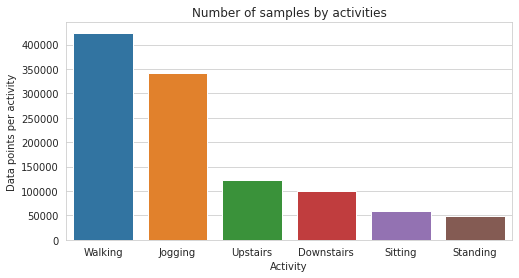

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of data points in class Walking = 424397 ~ 38.64%
Number of data points in class Jogging = 342176 ~ 31.16%
Number of data points in class Upstairs = 122869 ~ 11.19%
Number of data points in class Downstairs = 100427 ~ 9.14%
Number of data points in class Sitting = 59939 ~ 5.46%
Number of data points in class Standing = 48395 ~ 4.41%
--------------------------------------------------
total datapoints: 1098203


In [13]:
# analysis of class labels

label_dict = dict(har_df['activity'].value_counts())

sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = list(label_dict.keys()), y = list(label_dict.values()))
plt.xlabel('Activity')
plt.ylabel('Data points per activity')
plt.title('Number of samples by activities')
plt.show()

# Percentage-wise distribution of the class label yi's
print("- "* 50)
for i in label_dict.keys():
  print("Number of data points in class {0} = {1} ~ {2}%".format(
  i, label_dict[i], round((label_dict[i]*100)/sum(label_dict.values()), 2)))

print("-"*50)
print("total datapoints:", sum(label_dict.values()))

There is a significant class imbalance in the dataset.

### Data per User

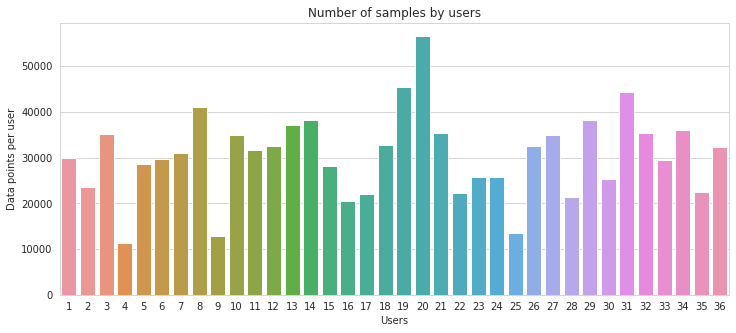

In [14]:
# User analysis

label_dict = dict(har_df['user'].value_counts())

sns.set_style("whitegrid")
plt.figure(figsize = (12, 5))
sns.barplot(x = list(label_dict.keys()), y = list(label_dict.values()))
plt.xlabel('Users')
plt.ylabel('Data points per user')
plt.title('Number of samples by users')
plt.show()

### User analysis: activity-wise

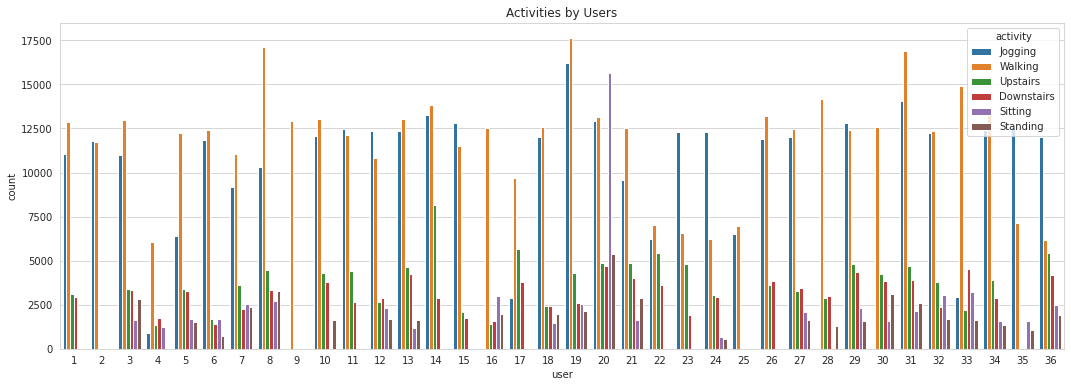

In [19]:
# User analysis: activity-wise

plt.figure(figsize = (18, 6))
sns.countplot(x = 'user', hue = 'activity', data = har_df)
plt.title('Activities by Users')
plt.show()

### Analysis of Signals

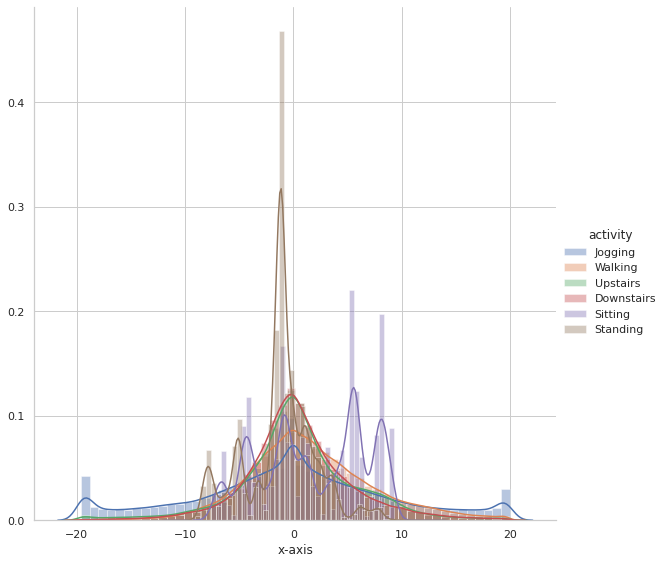

In [20]:
# x-axis

sns.set(style = 'whitegrid')
sns.FacetGrid(har_df, hue = 'activity', height = 8).map(sns.distplot, 'x-axis').add_legend()
plt.show()

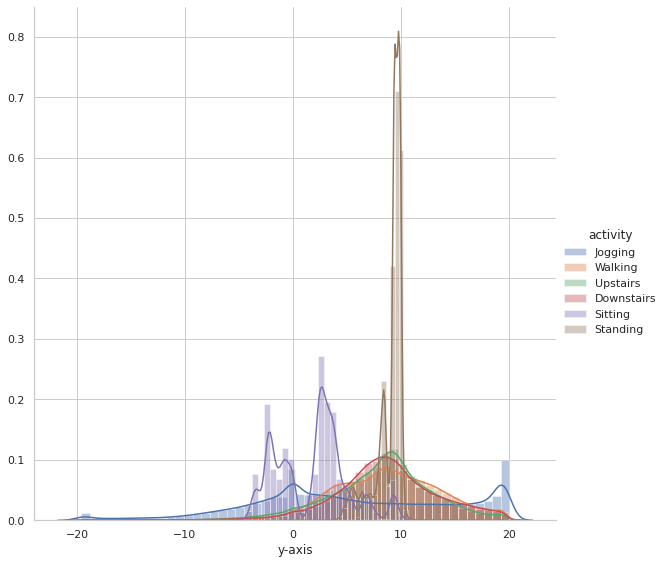

In [21]:
# y-axis

sns.FacetGrid(har_df, hue = 'activity', height = 8).map(sns.distplot, 'y-axis').add_legend()
plt.show()

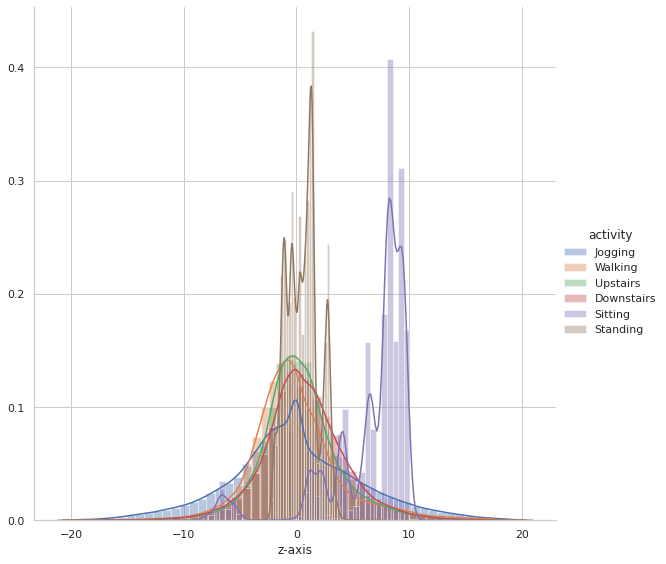

In [22]:
# z-axis

sns.FacetGrid(har_df, hue = 'activity', height = 8).map(sns.distplot, 'z-axis').add_legend()
plt.show()

In [23]:
def plot_activity(activity):
    data = har_df[har_df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:400]
    axis = data["x-axis"].plot(subplots=True, color="b", fontsize = 12)
    axis = data["y-axis"].plot(subplots=True, color="r", fontsize = 12)
    axis = data["z-axis"].plot(subplots=True, color="g", fontsize = 12)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5), fontsize = 12)



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Downstairs -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




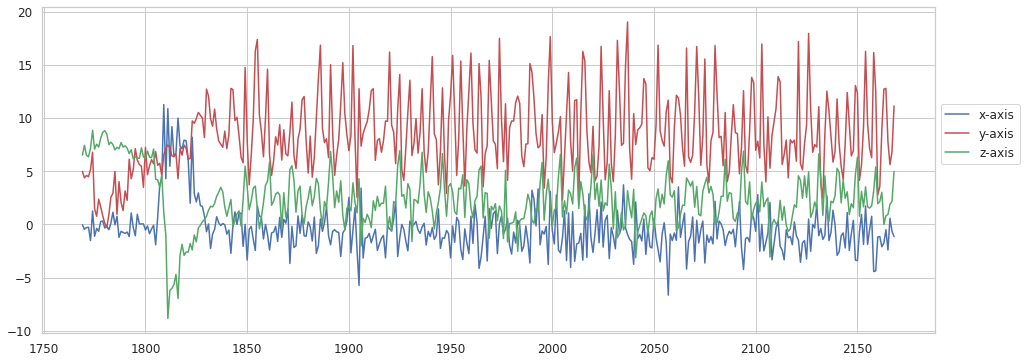



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Jogging -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




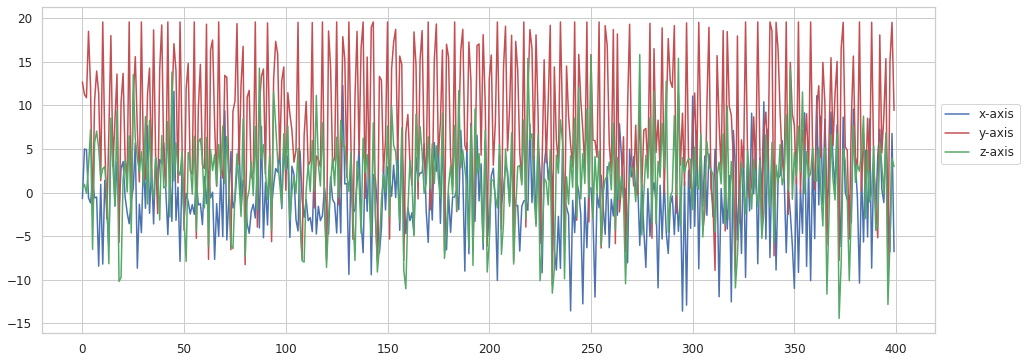



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Sitting -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




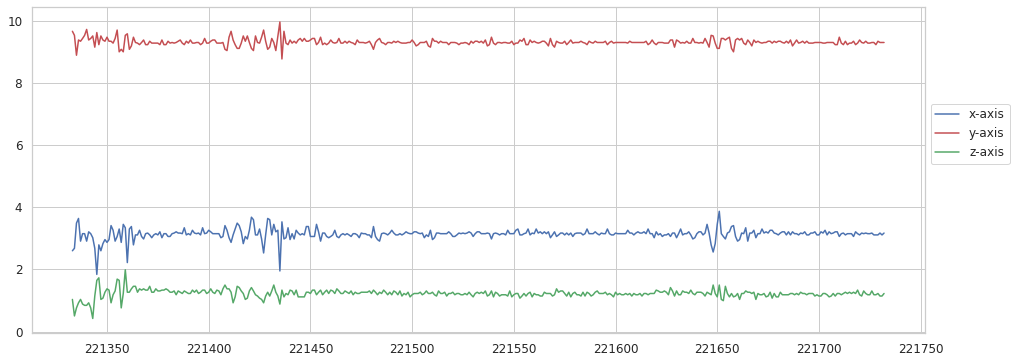



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Standing -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




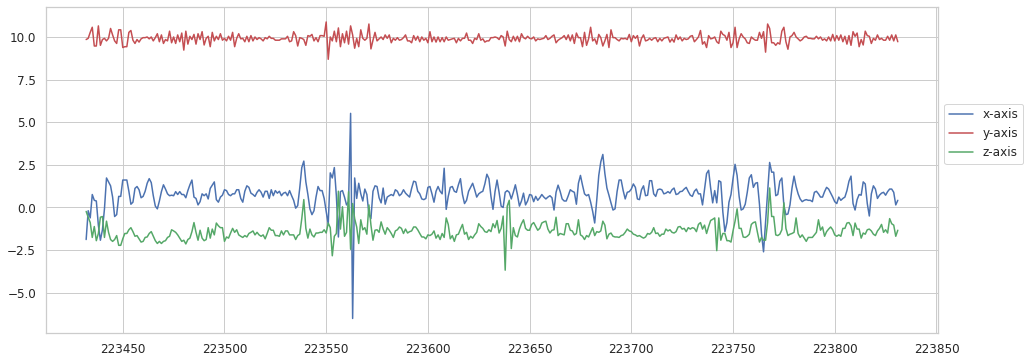



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Upstairs -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




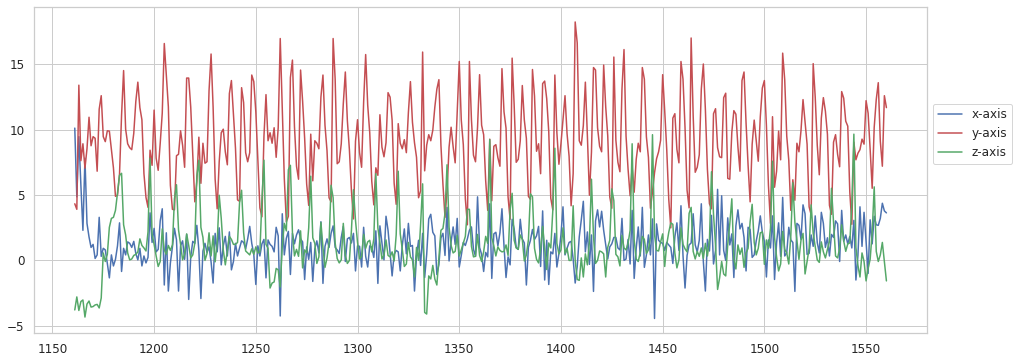



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Walking -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




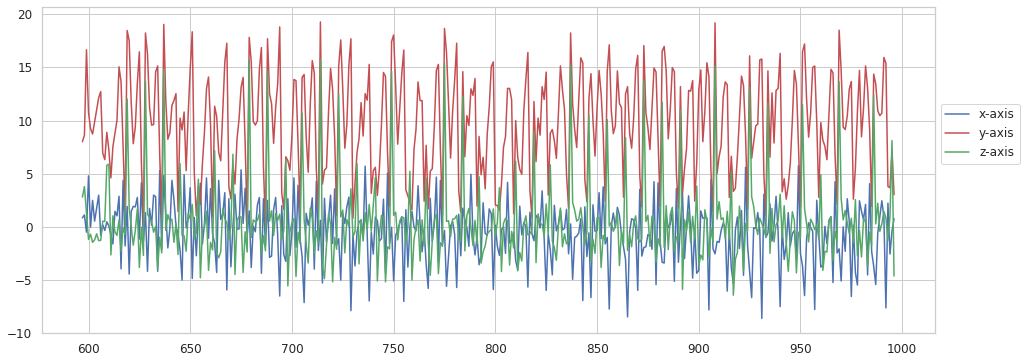

In [24]:
for i in np.unique(har_df['activity'].values):
    plt.figure(figsize = (16, 6))
    print("\n")
    print(" - "*15 + str(i) + " - "*15)
    print("\n")
    plot_activity(i)
    plt.show()

In [25]:
# drop the records where timestamp = 0
df = har_df[har_df['timestamp'] != 0]
print(df.shape)

# now arrange data in ascending order of the User and timestamp
df_sorted = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)
df_sorted

(1085360, 6)


,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1085355,36,Standing,15049012250000,-0.91,9.43,2.533385
1085356,36,Standing,15049062268000,-1.18,9.51,2.492524
1085357,36,Standing,15049112287000,-1.50,9.53,2.533385
1085358,36,Standing,15049162275000,-2.07,8.77,2.179256


## Modelling - Training LSTM Network

### Data Preprocessing

In [26]:
RANDOM_SEED = 24    
N_TIME_STEPS = 50   # 50 records in each sequence
N_FEATURES = 3      # x, y, z
step = 10           # window overlap = 50 -10 = 40  (80% overlap)
N_CLASSES = 6       # class labels
N_EPOCHS = 50       
BATCH_SIZE = 1024   
LEARNING_RATE = 0.0025
L2_LOSS = 0.0015

LSTM model expects fixed-length sequences as training data. Each generated sequence contains 50 training samples.

In [27]:
# step = 10
# N_TIME_STEPS = 50 
segments = []
labels = []

for i in range(0,  df_sorted.shape[0]-N_TIME_STEPS, step):  
    xs = df_sorted['x-axis'].values[i: i + 50]
    ys = df_sorted['y-axis'].values[i: i + 50]
    zs = df_sorted['z-axis'].values[i: i + 50]
    label = stats.mode(df_sorted['activity'][i: i + 50])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

#reshape the segments which is (list of arrays) to one list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
reshaped_segments.shape

(108531, 50, 3)

sanity check: 1085360 - 50 = 1085310       || 1085310/10 = 108531

Training dataset has reduced in size after the transformation. Note that the most common activity in a sequence is assigned as a label for the sequence.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(86824, 50, 3) (86824, 6)
(21707, 50, 3) (21707, 6)


In [39]:
# LSTM model

epochs = 50
batch_size =  1024

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape= (X_train.shape[1], X_train.shape[2]))) # input_shape = 50, 3
# Dropout layer
model.add(Dropout(0.4)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


Beacuse of so many trainable paraemter, the model tend to overfit easily. That is why a dropout layer is recommended to avoid overfitting.

### Training and Validation

In [41]:
# Training
history = model.fit(X_train, y_train, epochs = epochs, 
                    validation_split = 0.25, batch_size = batch_size, verbose = 1)

Epoch 1/50
64/64 [==============================] - 4s 28ms/step - loss: 1.3224 - accuracy: 0.4859 - val_loss: 0.5778 - val_accuracy: 0.7990
Epoch 2/50
64/64 [==============================] - 1s 19ms/step - loss: 0.5445 - accuracy: 0.8076 - val_loss: 0.4684 - val_accuracy: 0.8303
Epoch 3/50
64/64 [==============================] - 1s 19ms/step - loss: 0.4673 - accuracy: 0.8317 - val_loss: 0.4330 - val_accuracy: 0.8413
Epoch 4/50
64/64 [==============================] - 1s 19ms/step - loss: 0.4189 - accuracy: 0.8468 - val_loss: 0.3690 - val_accuracy: 0.8597
Epoch 5/50
64/64 [==============================] - 1s 19ms/step - loss: 0.3729 - accuracy: 0.8635 - val_loss: 0.3564 - val_accuracy: 0.8617
Epoch 6/50
64/64 [==============================] - 1s 19ms/step - loss: 0.3555 - accuracy: 0.8673 - val_loss: 0.3213 - val_accuracy: 0.8799
Epoch 7/50
64/64 [==============================] - 1s 19ms/step - loss: 0.3197 - accuracy: 0.8816 - val_loss: 0.2946 - val_accuracy: 0.8902
Epoch 8/50
64

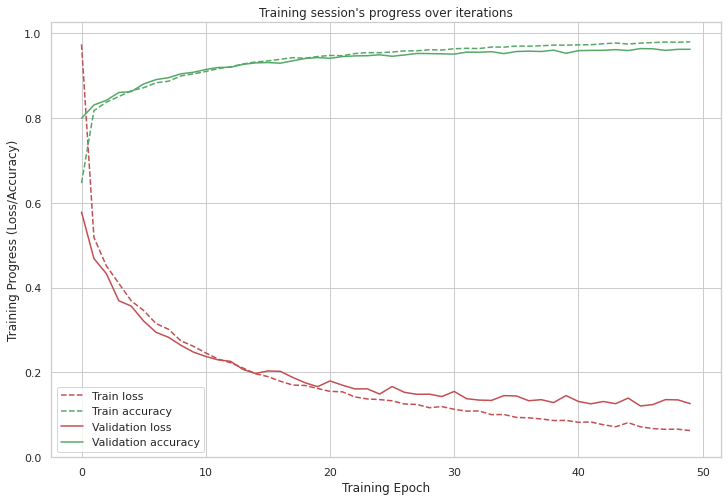

In [42]:
# Train and Validation: multi-class log-Loss & accuracy plot

plt.figure(figsize=(12, 8))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

### Model performance on Test data

In [44]:
# Test data loss & accuracy

loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("")
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.9614

Test Accuracy : 0.9613949656486511
Test Loss : 0.12968598306179047


### Confusion matrix

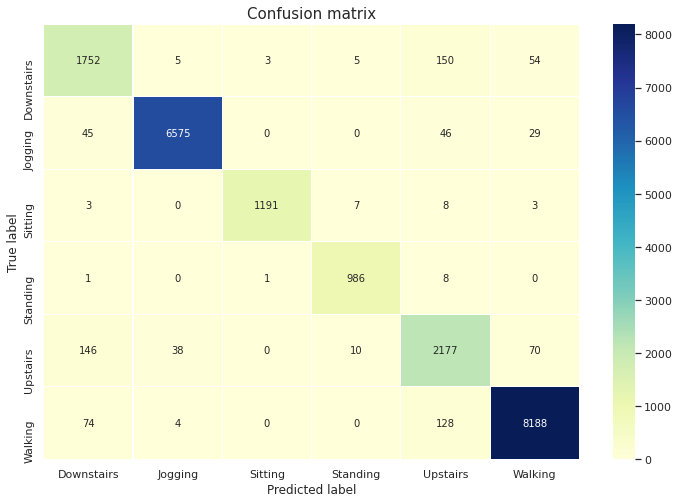

In [56]:
# Confusion Matrix

predictions = model.predict(X_test)
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True,
            linewidths = 0.1, fmt="d", cmap = 'YlGnBu');
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Recall matrix

In [59]:
new_array = []
for i in confusion_matrix:
    new_list = []
    for j in i:
        new_list.append(j/np.sum(i))
    new_array.append(new_list)

#print(new_array)
#print(np.array(new_array).reshape(6, 6))
recall_matrix = np.array(new_array).reshape(6, 6)

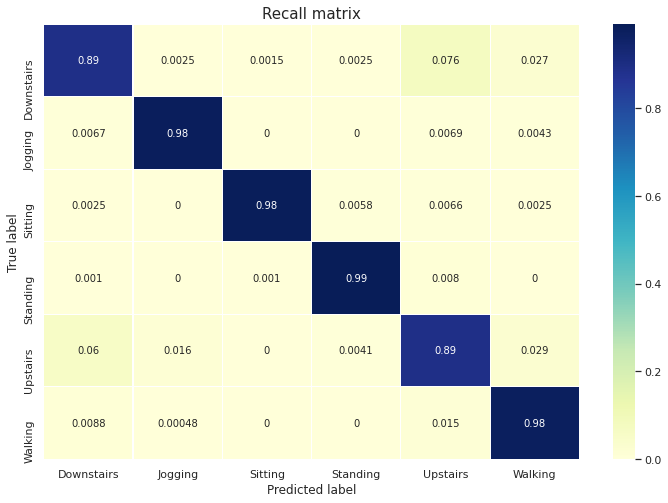

In [60]:
# Recall Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(recall_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            linewidths = 0.1, annot = True, cmap = 'YlGnBu')
plt.title('Recall matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Precision matrix

In [ ]:
# Precision Matrix 

pr_confusion_matrix = np.transpose(confusion_matrix)
new_array = []
for i in pr_confusion_matrix:
    new_list = []
    for j in i:
        new_list.append(j/np.sum(i))
    new_array.append(new_list)

#print(new_array)
#print(np.array(new_array).reshape(6, 6))
pr_matrix = np.array(new_array).reshape(6, 6)
pr_matrix = np.transpose(pr_matrix)

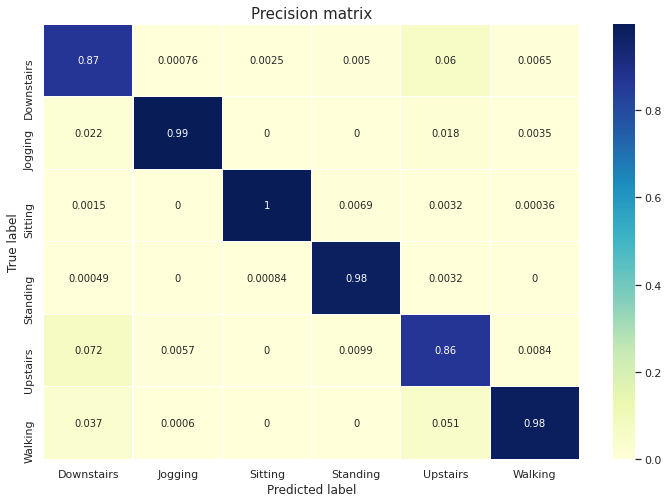

In [63]:
# Precision Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pr_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            linewidths = 0.1, annot=True, cmap = 'YlGnBu')
plt.title("Precision matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
# save model and architecture
from keras.models import load_model
model.save(mypath + 'har_model_50epochs.h5') 

with open(mypath + 'model_architecture.json', 'w') as f:
    f.write(model.to_json())